# Comparison of the wavefunctions to ARC(v3.8.1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from rydstate import RydbergStateSQDTAlkali

In [2]:
EXAMPLE_STATES = {
    "circular_120": (120, 119, 119.5, 119.5),
    "close_to_circular_123": (123, 120, 119.5, 119.5),
}

# Choose example states you want to look at
qns = [EXAMPLE_STATES["circular_120"], EXAMPLE_STATES["close_to_circular_123"]]

results = {}

In [ ]:
results["rydstate"] = []
for qn in qns:
    state = RydbergStateSQDTAlkali("Rb", n=qn[0], l=qn[1], j=qn[2])
    state.radial.create_grid()
    state.radial.create_wavefunction()
    results["rydstate"].append(
        {
            "x": state.radial.grid.x_list,
            "z": state.radial.grid.z_list,
            "u": state.radial.wavefunction.u_list,
            "w": state.radial.wavefunction.w_list,
        }
    )

In [4]:
import arc
import arc_fixed

atom = arc.Rubidium87()

for use_fixed_arc in [False, True]:
    key = "ARC fixed (>=v3.9)" if use_fixed_arc else f"ARC v{arc.__version__}"
    results[key] = []
    for qn in qns:
        r, psi_r = arc_fixed.radialWavefunction(atom, *qn[:3], use_fixed_arc=use_fixed_arc)
        arg_r_min = np.argwhere(psi_r != 0).flatten()[0]
        results[key].append(
            {
                "x": np.array(r),
                "z": np.sqrt(r),
                "u": np.array(psi_r),
                "w": np.array(psi_r) / np.power(r, 1 / 4),
            }
        )

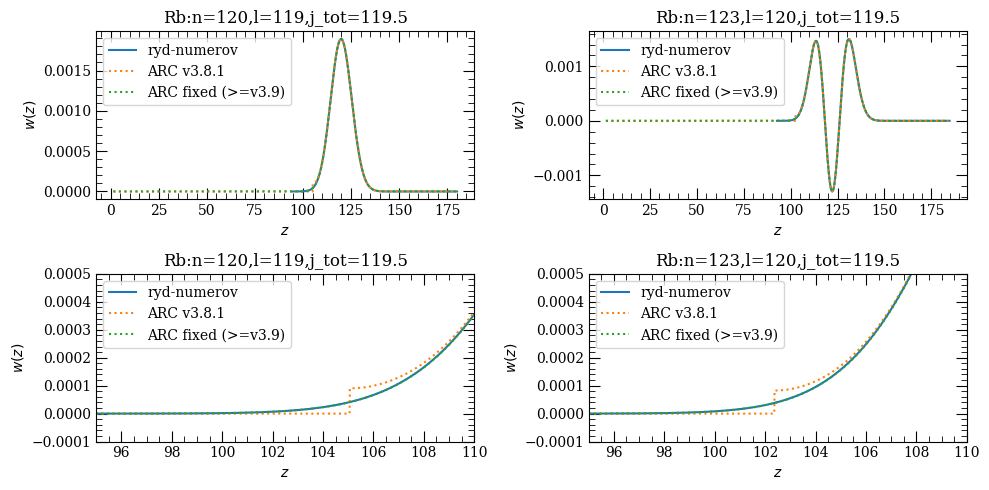

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for j, row in enumerate(axs):
    for i, ax in enumerate(row):
        for k, r_list in results.items():
            r = r_list[i]
            ls = {"rydstate": "-", "ARC v3.8.1": ":", "ARC fixed (>=v3.9)": ":"}.get(k, k)
            ax.plot(r["z"], r["w"], ls=ls, label=f"{k}")

        ax.set_xlabel(r"$z$")
        ax.set_ylabel(r"$w(z)$")
        ax.legend()
        ax.set_title(f"Rb:n={qns[i][0]},l={qns[i][1]},j_tot={qns[i][2]}")

        if j == 1:
            ax.set_xlim(95, 110)
            ax.set_ylim(-1e-4, 5e-4)

fig.tight_layout()
plt.show()

In [ ]:
# the small difference of the wavefunctions explains the difference in the radial matrix element of circular states
# (see also the compare_radial_matrix_element and compare_dipole_matrix_element notebooks)

from rydstate import ureg
from rydstate.radial.radial_matrix_element import calc_radial_matrix_element_from_w_z

to_mum = ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

for key in results:
    key1 = key2 = key
    i1, i2 = 0, 1
    overlap = calc_radial_matrix_element_from_w_z(
        results[key1][i1]["z"], results[key1][i1]["w"], results[key2][i2]["z"], results[key2][i2]["w"], k_radial=1
    )
    print(rf"matrix element <{key1}_{i1}|{key2}_{i2}> = {overlap * to_mum} micrometer")

matrix element <ryd-numerov_0|ryd-numerov_1> = 0.006611387237654362 micrometer
matrix element <ARC v3.8.1_0|ARC v3.8.1_1> = 0.007833542018452672 micrometer
matrix element <ARC fixed (>=v3.9)_0|ARC fixed (>=v3.9)_1> = 0.006614557031221676 micrometer
